# CRUD with Pinecone

The following is a CRUD exercise using [Pinecone](https://www.pinecone.io/product/), a commercial provider of fully managed vector database, following the FAISS sentence embedding exercise the week before.

To recall, sentence embedding is a way to tokenize or numerically represent sentences, as vectors.

Why use Pinecone? Pinecone supports real-time data updates, contrasts with standalone vector indexes, which may require a full re-indexing process to incorporate new data.

In [2]:
import requests
from io import StringIO
import pandas as pd


In [4]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    #'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]

sentences =[]

In [5]:
## Ingest data
for index, url in enumerate(urls):
  res = requests.get(url)
  if index == 0:
    data = pd.read_csv(StringIO(res.text), sep='\t')
    sentences = data['sentence_A'].tolist()
    sentences.extend(data['sentence_B'].tolist())
  else:
    data = pd.read_csv(StringIO(res.text), sep='\t', header=None, on_bad_lines='skip')
    sentences.extend(data[1].tolist())
    sentences.extend(data[2].tolist())

sentences = [word for word in list(set(sentences)) if type(word) is str]
len(set(sentences))

4802

In [6]:
## Build Dense Vectors using the sentence_transformers Bert Library
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=28881adf50512ad12f35f19a543e33d879e7ad10e4f7c0670d1c2479d9443d90
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
# Initialize sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')
# Create sentence embeddings
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

(4802, 768)

In [9]:
!pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 12.6 MB/s eta 0:00:00


In [10]:
import itertools
import pinecone

# create and upsert to a pinecone index

In [14]:
#check sentence shape again
sentence_embeddings.shape

(4802, 768)

In [27]:
print("Getting vectors as a list of lists...")
embeddings = sentence_embeddings.tolist()

Getting vectors as a list of lists...


In [28]:
vectors = list(zip(sentences, embeddings))

In [30]:
print("initialising Pinecone connection...")
pinecone.init(
	api_key='<insert-your-own-api-key-here>',
	environment='us-west1-gcp-free'
)

initialising Pinecone connection...


In [34]:
new_index_name='pineconepoc2'
print(f"Creating 768-dimensional index called '{new_index_name}'...")
pinecone.create_index(new_index_name, dimension=768)

Creating 768-dimensional index called 'pineconepoc2'...


# check pinecone online

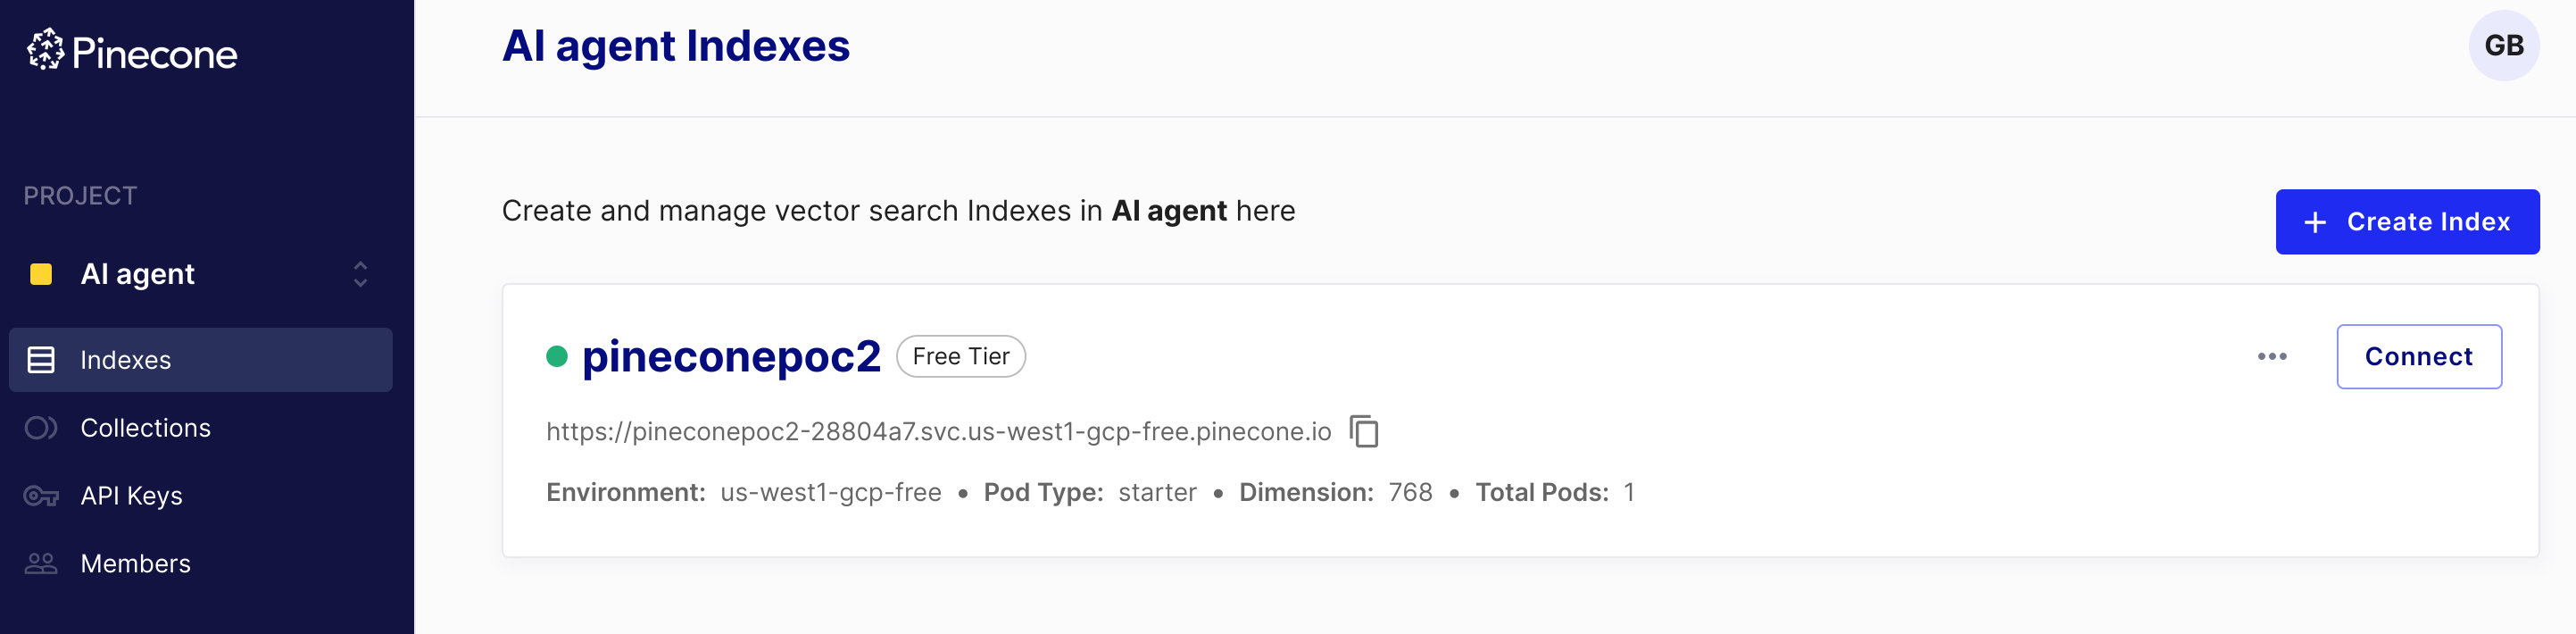

In [35]:
print("Checking Pinecone for active indexes...")
active_indexes = pinecone.list_indexes()
print("Active indexes:")
print(active_indexes)

Checking Pinecone for active indexes...
Active indexes:
['pineconepoc2']


In [36]:
print(f"Getting description for '{new_index_name}'...")
index_description = pinecone.describe_index(new_index_name)
print("Description:")
print(index_description)

Getting description for 'pineconepoc2'...
Description:
IndexDescription(name='pineconepoc2', metric='cosine', replicas=1, dimension=768.0, shards=1, pods=1, pod_type='p1', status={'ready': True, 'state': 'Ready'}, metadata_config=None, source_collection='')


In [37]:
print(f"Getting '{new_index_name}' as object...")
pinecone_index = pinecone.Index(new_index_name)
print("Success")

Getting 'pineconepoc2' as object...
Success


In [39]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [40]:
print("Upserting vectors in chunks of 100...")
counter = 1
for chunk in chunks(vectors, 100):
    print(f"Upserting chunk {counter}...")
    upsert_response = pinecone_index.upsert(
        vectors=chunk
        )
    print("done")
    counter += 1
print("Success")

Upserting vectors in chunks of 100...
Upserting chunk 1...
done
Upserting chunk 2...
done
Upserting chunk 3...
done
Upserting chunk 4...
done
Upserting chunk 5...
done
Upserting chunk 6...
done
Upserting chunk 7...
done
Upserting chunk 8...
done
Upserting chunk 9...
done
Upserting chunk 10...
done
Upserting chunk 11...
done
Upserting chunk 12...
done
Upserting chunk 13...
done
Upserting chunk 14...
done
Upserting chunk 15...
done
Upserting chunk 16...
done
Upserting chunk 17...
done
Upserting chunk 18...
done
Upserting chunk 19...
done
Upserting chunk 20...
done
Upserting chunk 21...
done
Upserting chunk 22...
done
Upserting chunk 23...
done
Upserting chunk 24...
done
Upserting chunk 25...
done
Upserting chunk 26...
done
Upserting chunk 27...
done
Upserting chunk 28...
done
Upserting chunk 29...
done
Upserting chunk 30...
done
Upserting chunk 31...
done
Upserting chunk 32...
done
Upserting chunk 33...
done
Upserting chunk 34...
done
Upserting chunk 35...
done
Upserting chunk 36...
done

# Test query

In [41]:
query_strings = [
    # Semantic search for concepts:
    "Someone runs with a football",
]

In [42]:
query_vector = model.encode(query_strings).tolist()

In [43]:
print("Searching for similar...")
query_results = pinecone_index.query(
    queries=query_vector,
    top_k=5,
    include_values=True
    )

for i in range(len(query_results.results)):
    print(f'\n\nSimilar results for "{query_strings[i]}":')
    for match in query_results.results[i].matches:
        print(f'"{match.id}" ({round(match.score*100, 2)}% similar)')

Searching for similar...


Similar results for "Someone runs with a football":
"Two groups of people are playing football" (90.17% similar)
"A group of people playing football is running in the field" (89.5% similar)
"A group of football players is running in the field" (89.48% similar)
"A person playing football is running past an official carrying a football" (88.24% similar)
"Different teams are playing football on a field" (86.27% similar)
